# Week 04: Multi-class Classification

## Introduction


In this exercise, we will implement logistic regression based multiclass classification to recognize handwritten digits. 

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
import scipy.optimize as opt


# Module to load MATLAB .mat datafile format (Input and output module of scipy)
from scipy.io import loadmat

# Python Imaging Library (PIL)
from PIL import Image

# tells matplotlib to embed plots within the notebook
%matplotlib inline
from functools import partial

## Multi-class Classification

For this exercise, logistic regression will be used to recognize handwritten digits (from 0 to 9).

### Dataset

The data set is given in `mnist-digit.mat` that contains 5000 training examples of handwritten digits. Use the function `loadmat` within the `scipy.io` module to load the data.

There are 5000 training examples in `mnist-digit.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix `X`. This gives us a 5000 by 400 matrix `X` where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set.



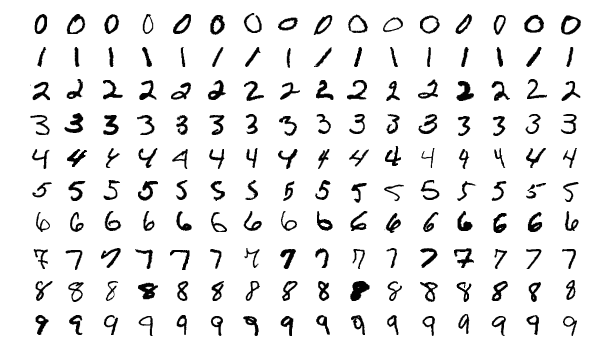

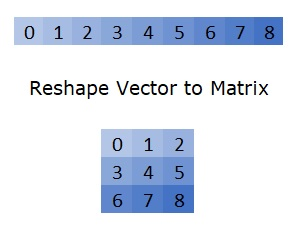

In [2]:
DATA_DIR = os.path.join(os.getcwd(), 'DATA')
SAVE_DIR = os.path.join(os.getcwd(), 'Plots')

In [3]:
# Load data
data = loadmat(os.path.join(DATA_DIR, 'mnist-digit.mat'))
print('Data Keys:', data.keys())
print('Data Shape:', data['X'].shape,data['y'].shape)
print('Labels:', np.unique(data['y']))

Data Keys: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Data Shape: (5000, 400) (5000, 1)
Labels: [ 1  2  3  4  5  6  7  8  9 10]


In [4]:
# 10 labels, from 1 to 10 (note that you have to map "0" to label "10")
data['y'][data['y']==10]=0
print('Labels:', np.unique(data['y']))

Labels: [0 1 2 3 4 5 6 7 8 9]


### MATLAB Data

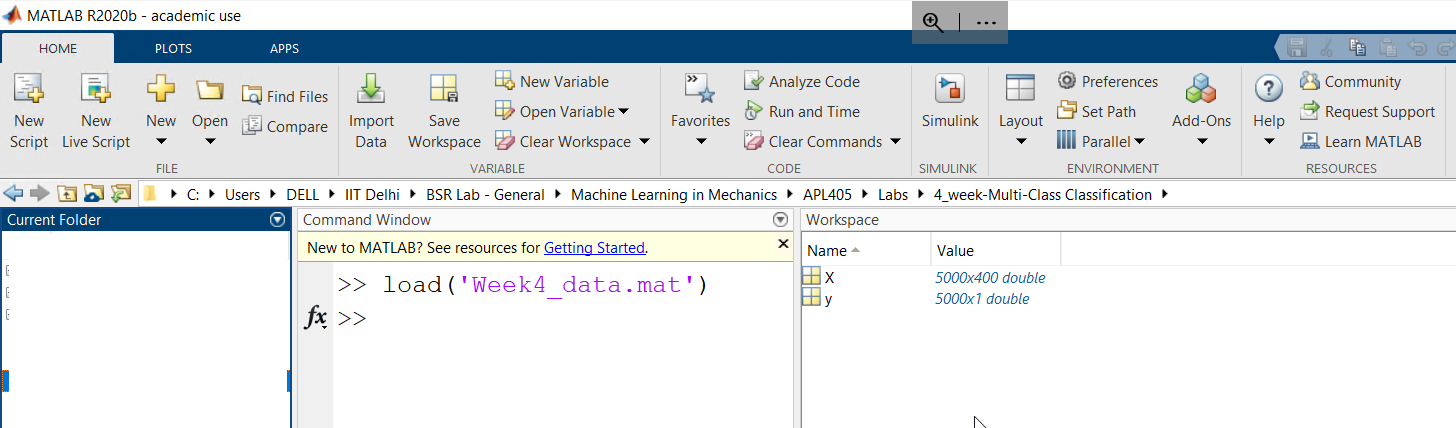

### Definition of useful functions that are going to be used thoughout the code

In [27]:
def displayData(X,y,y_pred=None , save_img_dir=None):
    """
    Displays the data from X
    """
    import random
    # Create figure
    fig, ax = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize=(10, 12))
    for r in range(10):
        for c in range(10):
            res = random.sample(range(1, 5000), 1)
            ax[r, c].matshow(X[res][0].reshape((20,20)).T, cmap='binary')
            if y_pred is not None:
                if y[res][0] == y_pred[res][0]:
                    ax[r,c].title.set_color('green')
                    ax[r,c].title.set_text(y[res][0])
                else:
                    ax[r,c].title.set_color('red')
                    ax[r,c].title.set_text(y_pred[res][0])
            else:
                ax[r,c].title.set_text(y[res][0])
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
        plt.tight_layout()
        if save_img_dir is not None:

            plt.savefig(os.path.join(save_img_dir))

    plt.show();


            
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

### Visualize the data

To visualize the data that you imported, randomly selects 100 rows from `X` and passes those rows to the `displayData` function.

Randomly select data points to display

In [6]:
save_img_dir=os.path.join(SAVE_DIR, '0101.png')

/home/kulwinder/.local/lib/python3.10/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


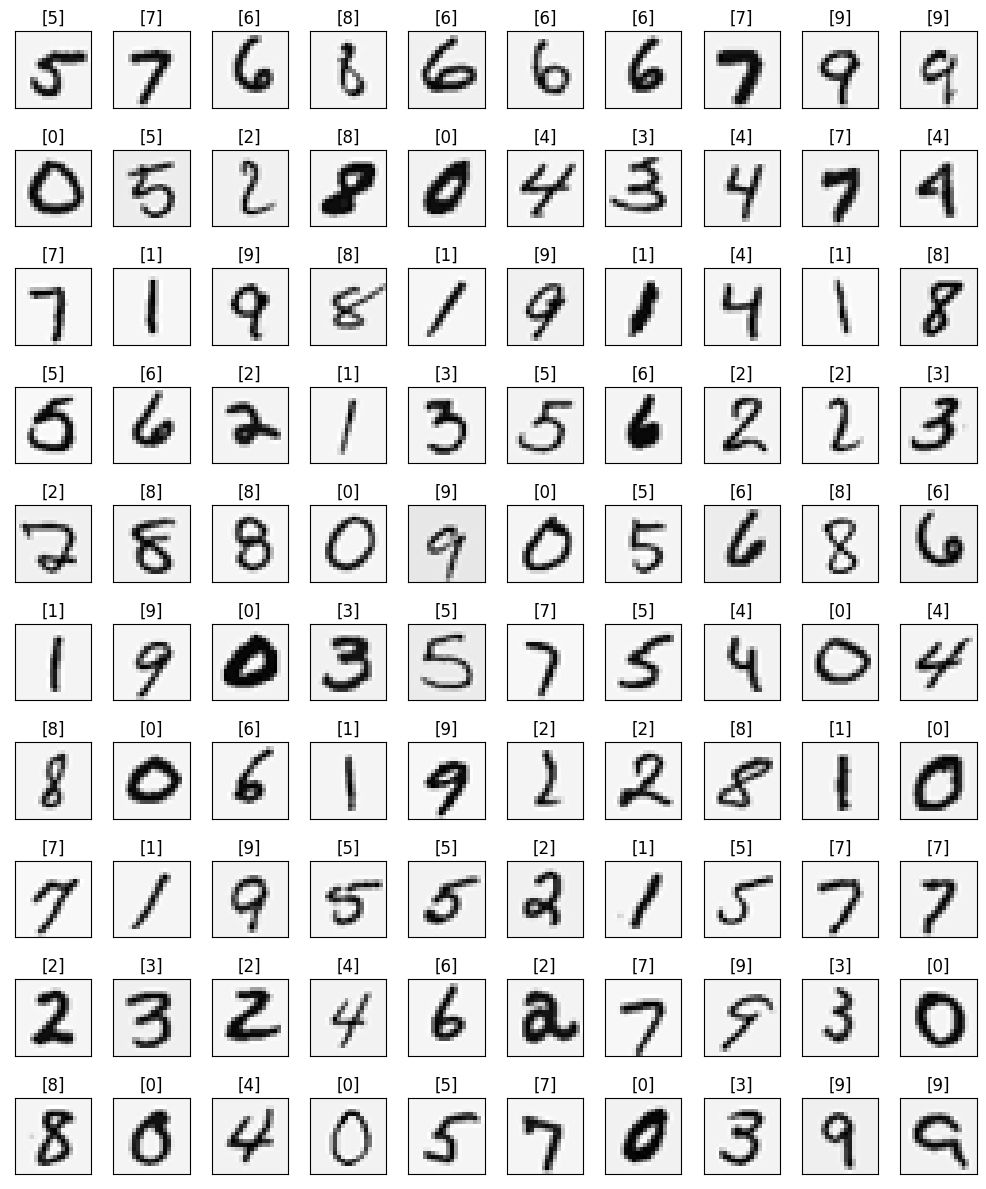

In [7]:
displayData(data['X'],data['y'],save_img_dir=save_img_dir)

<a id="section1"></a>
#### Vectorizing the cost function 

Begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$$ J(w) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_w\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_w \left( x^{(i)} \right) \right) \right] $$

To compute each element in the summation, we have to compute $h_w(x^{(i)})$ for every example $i$, where $h_w(x^{(i)}) = g(w^T x^{(i)})$ and $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $X$ and $w$ as

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad w = \begin{bmatrix} w_0 \\ w_1 \\ \vdots \\ w_n \end{bmatrix} $$

Then, by computing the matrix product $Xw$, we have: 

$$ Xw = \begin{bmatrix} - \left( x^{(1)} \right)^Tw - \\ - \left( x^{(2)} \right)^Tw - \\ \vdots \\ - \left( x^{(m)} \right)^Tw - \end{bmatrix} = \begin{bmatrix} - w^T x^{(1)}  - \\ - w^T x^{(2)} - \\ \vdots \\ - w^T x^{(m)}  - \end{bmatrix} $$

#### Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^{th}$ element is defined as

$$ \frac{\partial J }{\partial w_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_w\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $w_j$,

$$
\begin{aligned}
\begin{bmatrix} 
\frac{\partial J}{\partial w_0} \\
\frac{\partial J}{\partial w_1} \\
\frac{\partial J}{\partial w_2} \\
\vdots \\
\frac{\partial J}{\partial w_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_w(x) - y\right)
\end{aligned}
$$

where

$$  h_w(x) - y = 
\begin{bmatrix}
h_w\left(x^{(1)}\right) - y^{(1)} \\
h_w\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_w\left(x^{(m)}\right) - y^{(m)} 
\end{bmatrix} $$

Note that $x^{(i)}$ is a vector, while $h_w\left(x^{(i)}\right) - y^{(i)}$  is a scalar (single number).
To understand the last step of the derivation, let $\beta_i = (h_w\left(x^{(m)}\right) - y^{(m)})$ and
observe that:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix} 
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & | 
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

where the values $\beta_i = \left( h_w(x^{(i)} - y^{(i)} \right)$.

Now the job is to define a new function (`lrCostFunction`) which will take the data (vectors `X` and `y`) and parameter (`Lambda`) as input and return the cost as a scalar. 

#### Regularized logistic regression

Now add regularization to the cost function. For regularized logistic regression, the cost function is defined as

$$ J(w) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_w\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_w \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n w_j^2 $$

Note that $w_0$ should not be regularized as it is used as bias term.
Correspondingly, the partial derivative of regularized logistic regression cost for $w_j$ is defined as

$$
\begin{aligned}
& \frac{\partial J(w)}{\partial w_0} = \frac{1}{m} \sum_{i=1}^m \left( h_w\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(w)}{\partial w_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_w\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} w_j & \text{for } j  \ge 1
\end{aligned}
$$

In [8]:
def lrCostFunction(w, X, y, lambda_,shape=False):
    
    m = y.size
    
    if y.dtype == bool:
        y = y.astype(int)

    h = sigmoid(np.dot(X,w))
    grad = np.zeros(w.shape)
    reg_term = (lambda_/(2*m))*np.sum(w[1:]**2)
    J = (1/m)*np.sum(-y*np.log(h+1e-10) - (1-y)*np.log(1-h+1e-10)) + reg_term
    grad[0] = (1/m)*np.dot((h-y),X[:,0])
    grad[1:]=(1/m)*(np.dot((h-y),X[:,1:])) + (lambda_/m) * w[1:]
    if shape:
        print('shape of grad: ', grad.shape)
        print('shape of J: ', J.shape)
        print('shape of h: ', h.shape)
        print('shape of w: ', w.shape)
        print('shape of X: ', X.shape)
        print('shape of y: ', y.shape)
    
    return J, grad

<a id="section2"></a>
### Multi-class Classification

In this part of the exercise, you will implement multi-class classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset.

Code for the function `oneVsAll` below, to train one classifier for each class. In particular, the code should return all the classifier parameters in a matrix $w \in \mathbb{R}^{K \times (N +1)}$, where each row of $w$ corresponds to the learned logistic regression parameters for one class. One can do this with a “for”-loop from $0$ to $K-1$, training each classifier independently.

The obvious approach is to use a one-versus-the-rest approach (also called one-vs-all), in which we train C binary classifiers, fc(x), where the data from class c is treated as positive, and the data from all the other classes is treated as negative.

<a id="oneVsAll"></a>

In [9]:
def callback_partial(W, X, y, history,):
    J, _ = lrCostFunction(W, X, y, lambda_)
    history.append(J)

In [10]:

def oneVsAll(X, y, num_labels, lambda_):
        
    m, n = X.shape  
    
    all_w = np.zeros((num_labels, n ))
    all_j = []
    w = np.zeros(n)

    for c in np.arange(num_labels):
        J_history = []
        print(f"Currently Training for {c}", end="\r")
        y_c = np.where(y==c,1,0)        
        callbackF = partial(callback_partial, X=X, y=y_c, history=J_history)
        res = opt.minimize(lrCostFunction, w, args=(X,y_c,lambda_), method='CG', jac=True,callback=callbackF, options={'maxiter': 100}, tol=1e-6)
        all_w[c] = res.x
        # print(res)
        all_j.append(J_history)
        # print('class: ', c, 'cost: ', res.fun)

    return all_w, all_j

After complting the code for `oneVsAll`, the following cell shall use the code to train a multi-class classifier. 

In [11]:
X = data['X']
y = data['y']
y = y.squeeze()
y = np.where(y==10,0,y)

In [12]:
X_final = np.hstack((np.ones((X.shape[0],1)),X))

Shuffling and splitting the data into training and test sets. The training set will be used to learn the parameters for each classifier, while the test set will be used to evaluate how well the learned parameters generalize to new examples.

In [13]:
data_con = np.c_[X_final,y]

Shuffling the data

In [14]:
np.random.shuffle(data_con)

In [15]:
X_train = data_con[:4000,:-1]
y_train = data_con[:4000,-1]
X_test = data_con[4000:,:-1]
y_test = data_con[4000:,-1]

In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4000, 401), (4000,), (1000, 401), (1000,))

In [17]:
lambda_ = 0.1
all_w , all_J= oneVsAll(X_train, y_train, 10, lambda_)

In [18]:
print(all_w.shape) # 10 X 401

(10, 401)


<a id="section3"></a>
#### Multi-class Prediction

After training one-vs-all classifier, one can now use it to predict the digit contained in a given image. For each input, one should compute the “probability” that it belongs to each class using the trained logistic regression classifiers. The one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (0, 1, ..., K-1) as the prediction for the input example.
<a id="predictOneVsAll"></a>

In [19]:
def predictOneVsAll(all_w, X):
        
    pred = np.argmax(sigmoid(X.dot(all_w.T)), axis=1)
    assert pred.shape == (X.shape[0],)
    return pred

Now, call `predictOneVsAll` function using the learned value of $w$. One should see the training set accuracy in percentage which shows that the algorithm classifies `p%` of the examples in the training set correctly.

In [20]:
pred = predictOneVsAll(all_w, X_train)
accuracy =  np.mean(pred == y_train)
print(f"Training set Accuracy: {accuracy*100:.2f}%")

Training set Accuracy: 96.43%


Prediction on test data

In [21]:
pred = predictOneVsAll(all_w, X_test)
accuracy =  np.mean(pred == y_test)
print(f"Test set Accuracy: {accuracy*100:.2f}%")

Test set Accuracy: 90.40%


Prediction on whole data

In [22]:
X_all = X_final = np.hstack((np.ones((data['X'].shape[0],1)),data['X']))
y_all = data['y'].squeeze()
y_all = np.where(y_all==10,0,y_all)

In [23]:
y_pred = predictOneVsAll(all_w, X_all)
accuracy =  np.mean(y_pred == y_all)
print(f" Total Accuracy: {accuracy*100:.2f}%")

 Total Accuracy: 95.22%


In [157]:
SAVE_DIR = os.path.join(os.getcwd(), 'Plots')
SAVE_DIR

'/home/kulwinder/Desktop/sem4/APL745/Assignments/A3/Plots'

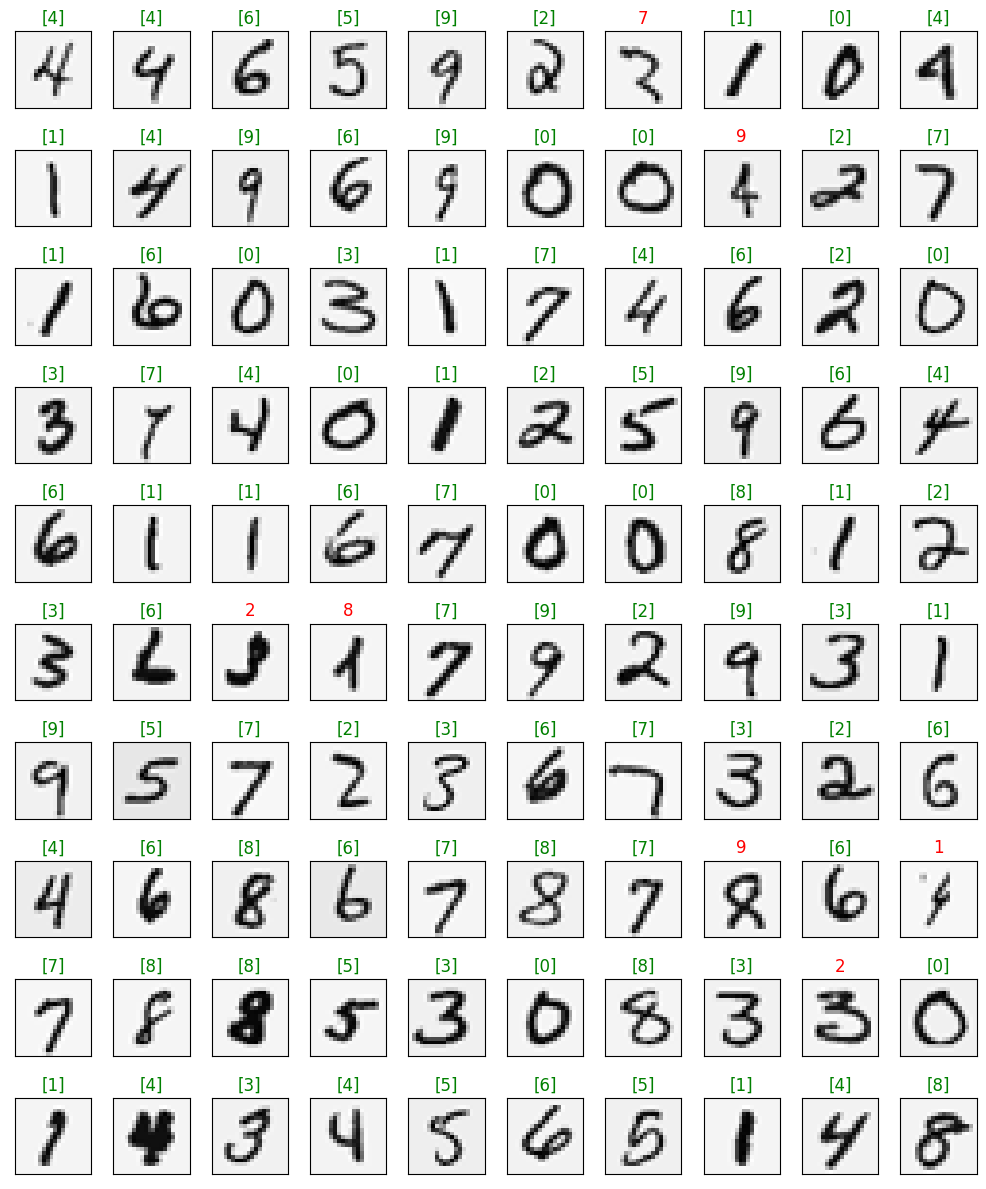

In [28]:
displayData(data['X'],data['y'],y_pred=y_pred,save_img_dir=os.path.join(SAVE_DIR, '0102.png'))

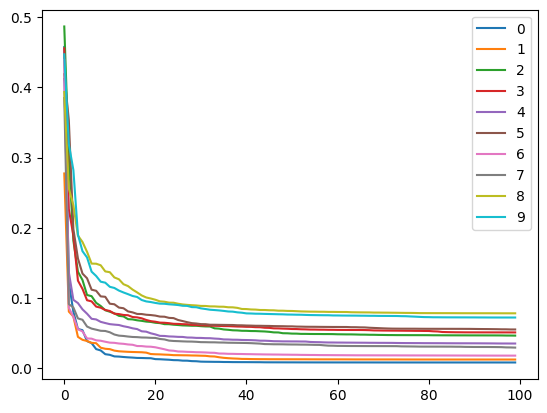

In [25]:
all_j = np.array(all_J)
for i in range(10):
    plt.plot(all_j[i], label=i)
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, '0103.png'))
plt.show()

# FASHION-MNIST

In [32]:
import pandas as pd

In [33]:
DATA_DIR

'/home/kulwinder/Desktop/sem4/APL745/Assignments/A3/DATA'

In [34]:
df_train = pd.read_csv(os.path.join(DATA_DIR, 'fashion-mnist_train.csv'))
df_test = pd.read_csv(os.path.join(DATA_DIR, 'fashion-mnist_test.csv'))

In [35]:
df_train.head(2)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0


In [36]:
X_train = df_train.iloc[:,1:].values
y_train = df_train.iloc[:,0].values
X_test = df_test.iloc[:,1:].values
y_test = df_test.iloc[:,0].values

In [37]:
X_train.shape, y_train.shape

((10000, 784), (10000,))

In [38]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [54]:
def displayData_fashion(X,y,y_pred=None , save_img_dir=None):
    """
    Displays the data from X
    """
    import random
    # Create figure
    fig, ax = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize=(10, 12))
    for r in range(10):
        for c in range(10):
            res = random.sample(range(1, 5000), 1)
            ax[r, c].matshow(X[res][0].reshape((28,28)), cmap='binary')
            if y_pred is not None:
                if y[res][0] == y_pred[res][0]:
                    ax[r,c].title.set_color('green')
                    ax[r,c].title.set_text(y[res][0])
                else:
                    ax[r,c].title.set_color('red')
                    ax[r,c].title.set_text(y_pred[res][0])
            else:
                ax[r,c].title.set_text(y[res][0])
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
        if save_img_dir is not None:

            plt.savefig(os.path.join(save_img_dir))
    plt.show();

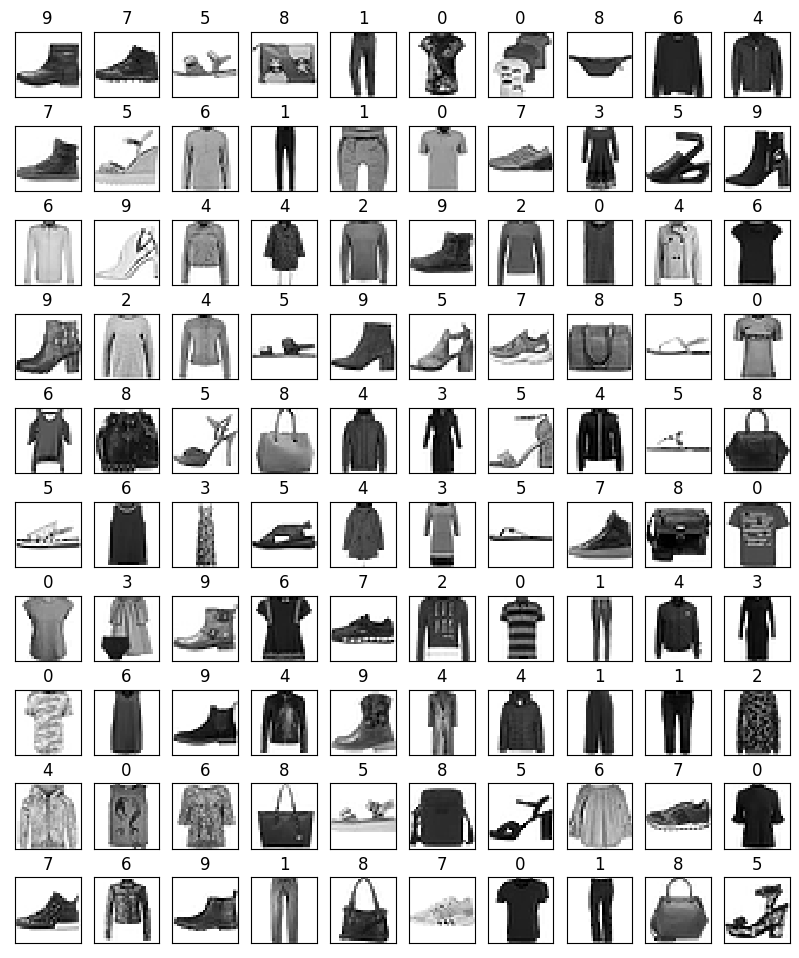

In [42]:
displayData_fashion(X_train,y_train, save_img_dir=os.path.join(SAVE_DIR, '0104.png'))

In [43]:
X_train_final = np.hstack((np.ones((X_train.shape[0],1)),X_train))/255
X_test_final = np.hstack((np.ones((X_test.shape[0],1)),X_test))/255

In [44]:
X_train_final.shape

(10000, 785)

In [46]:
lambda_ = 0.1
all_w_2 , all_J_2= oneVsAll(X_train_final, y_train, 10, lambda_)

In [47]:
print(all_w_2.shape) 

(10, 785)


In [48]:
pred = predictOneVsAll(all_w_2, X_train_final)
accuracy =  np.mean(pred == y_train)
print(f"Training set Accuracy: {accuracy*100:.2f}%")

Training set Accuracy: 90.07%


In [49]:
pred_test = predictOneVsAll(all_w_2, X_test_final)
accuracy =  np.mean(pred_test == y_test)
print(f"Test set Accuracy: {accuracy*100:.2f}%")


Test set Accuracy: 86.67%


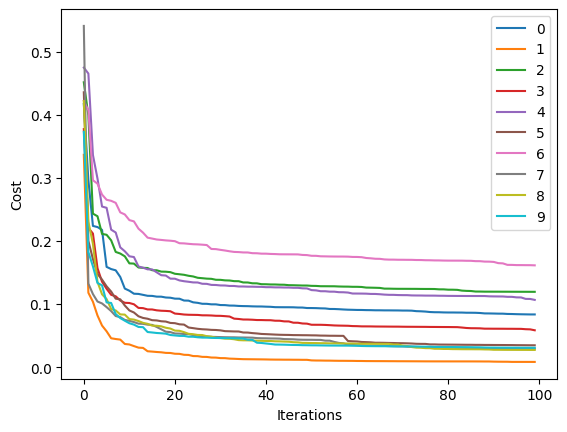

In [51]:
all_J_2 = np.array(all_J_2)
for i in range(10):
    plt.plot(all_J_2[i], label=i)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, '0105.png'))
plt.show()

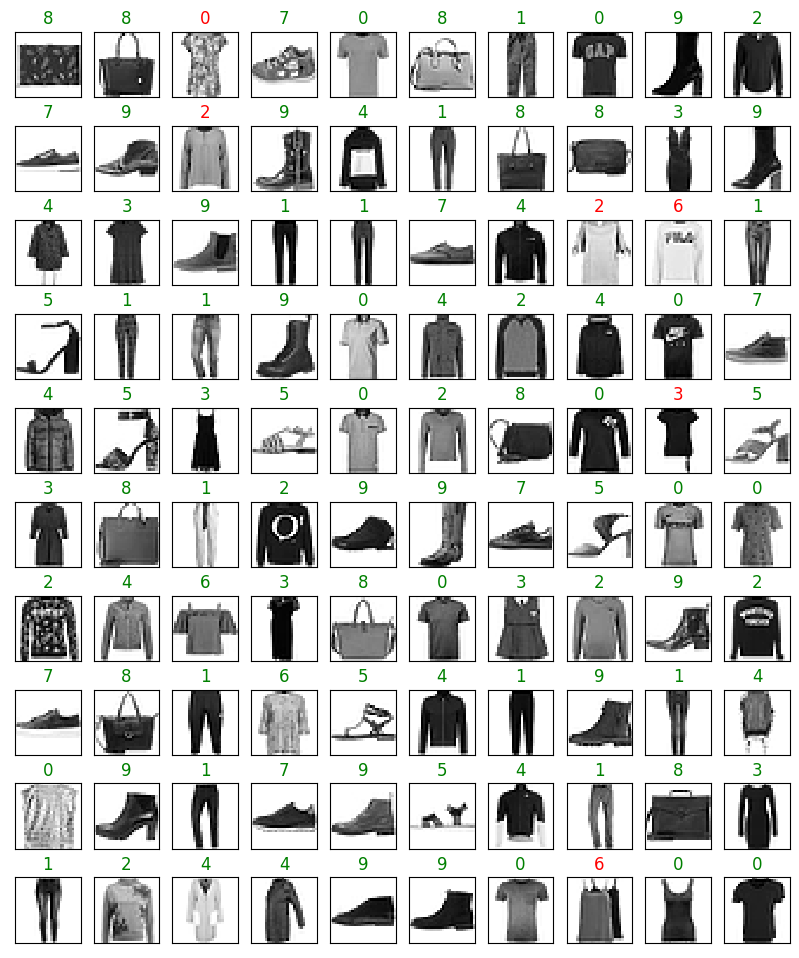

In [55]:
displayData_fashion(X_train,y_train,y_pred=pred, save_img_dir=os.path.join(SAVE_DIR, '0106.png'))